In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('../Style.mplstyle')
import pandas as pd
import os
import sys
import linecache
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import periodictable
from sklearn.metrics import davies_bouldin_score
from NFA_Aerosol import Utility_Lib as UL
from NFA_Aerosol import Instrument_Lib as IL
sys.path.append('..')
from read_data_functions import *
from plot_functions import *
from calculations import *

In [2]:
def read_SEM(path, parent_path):
    ParentPath = os.path.abspath(parent_path)
    if ParentPath not in sys.path:
        sys.path.insert(0, ParentPath)
    
    files = os.listdir(path)

    dfs = []
    for file in files:
        if file.endswith('.xlsx'):
            file_path = os.path.join(path, file)
            temp = pd.read_excel(file_path)

            # Extracting sample name from the directory structure
            # sample_name = os.path.basename(os.path.dirname(file_path))
            sample_name = file.split('-')[0]
            temp["Sample"] = [sample_name] * temp.shape[0]

            dfs.append(temp)

    if not dfs:
        return pd.DataFrame()  # Return an empty DataFrame if no files were processed

    # Combine all DataFrames
    combined_df = pd.concat(dfs, ignore_index=True)

    # Unique sample mapping
    unique_samples = combined_df['Sample'].unique()
    mapping = {original: f"Sample {i+1}" for i, original in enumerate(unique_samples)}
    combined_df['Sample'] = combined_df['Sample'].map(mapping)

    # Drop specified columns if they exist
    combined_df = combined_df.drop(columns=["Field", "Stage X", "Stage Y", "Id"], errors='ignore')

    return combined_df

parent_path = '../../../../'
path = 'L:/PG-Nanoteknologi/PROJEKTER/2024 Laura og Nan/Lund/'

SEM = read_SEM(path + 'SEM/', parent_path)

partector_keys = ['101024_20241016', '142542_20241016', '091255_20241017', '131923_20241017']
partector = read_partector(path + 'Partector/', parent_path, partector_keys)
for key in partector_keys:
    partector[key]['Time'] = partector[key]['Time'].dt.to_pydatetime()
combined_Partector = pd.concat(partector.values(), ignore_index=True).to_numpy()
# combined_Partector = combined_Partector.to_numpy()
# print(combined_Partector)

durations,starts = Partector_TEM_sampling(combined_Partector)

sampled_air = np.array(durations)*450 # cm3
removed = np.array([sampled_air[1], sampled_air[3]])
sampled_air = np.setdiff1d(sampled_air, removed)

print(sampled_air)

Img_area_mm2 = 8192 * (10.2 * 1e-6) * 5632 * (10.2 * 1e-6)
Img_number = 5

TEM_grid_area_mm2 = np.pi * (3.05/2)**2
TEM_grid_area_mm2 = np.pi * (2.9/2)**2

Fraction_area_analyzed = (Img_area_mm2*Img_number) / TEM_grid_area_mm2

Start: 2024-10-16 10:10:43, Duration: 156.05 minutes
Start: 2024-10-16 12:46:51, Duration: 99.12 minutes
Start: 2024-10-16 14:26:00, Duration: 122.20 minutes
Start: 2024-10-16 16:28:20, Duration: 0.05 minutes
Start: 2024-10-17 09:13:28, Duration: 181.33 minutes
Start: 2024-10-17 13:19:40, Duration: 135.80 minutes
[54990.  61110.  70222.5 81600. ]


In [3]:
size_bins = np.array([  10.  ,  13.45,  17.95,  23.95,  31.95,  42.6 ,  56.8 ,  75.75,
101.05, 134.75, 179.7 , 239.6, 300.,   374.,   465.,   579.,   721.,   897.,  1117.,  1391.,
1732.,  2156.,  2685.,  3343.,  4162.,  5182.,  6451.,  8031., 10000.])

width = size_bins[1:]-size_bins[:-1]
Mids = width/2 + size_bins[:-1]

log_bin_edges = np.log10(size_bins)
dlogDP = log_bin_edges[1:] - log_bin_edges[:-1]

Partector_correction = Partector_Ceff(Mids)

size_labels = np.arange(size_bins.shape[0]-1)

SEM["Size Category"] = pd.cut(SEM["ECD (μm)"] * 1000, bins=size_bins, labels=size_labels)

# Define number of samples
samples = SEM["Sample"].unique()
num_samples = len(samples)

In [4]:
background_elements = ['C Wt%', 'O Wt%', 'Cu Wt%', "Al Wt%", "F Wt%","Eu Wt%","Mn Wt%","Ba Wt%","Os Wt%","Yb Wt%","Tb Wt%","P Wt%","Ta Wt%","Mo Wt%"]

# Identify element columns (atomic % data)
element_columns = [col for col in SEM.columns if col.endswith(" Wt%") and col not in background_elements]

# Identify non-element columns (to keep)
non_element_columns = [col for col in SEM.columns if col not in element_columns + background_elements]

# Compute total sum of non-background elements per row
total_remaining = SEM[element_columns].sum(axis=1)

# Create a mask for rows where only background elements are present
background_only_mask = total_remaining == 0

# Renormalize: Scale remaining elements so that their sum becomes 100%
df_normalized = SEM[element_columns].div(total_remaining, axis=0) * 100

# Apply the mask: If only background elements were present, set values to NaN
df_normalized[background_only_mask] = float("nan")

# Merge back with original non-elemental columns (Size, Shape, etc.)
df_final = pd.concat([SEM[non_element_columns], df_normalized], axis=1)

In [5]:
# Dynamically fetch atomic masses using `periodictable`
def get_atomic_mass(element):
    try:
        return periodictable.elements.symbol(element).mass
    except KeyError:
        raise ValueError(f"Element {element} not found in periodictable")
        
# Calculate At% for each particle (row)
for col in element_columns:
    element = col.split(" ")[0]  # Extract the element name (e.g., "Fe" from "Fe Wt%")
    atomic_mass = get_atomic_mass(element)
    # Calculate molar ratio (Wt% / Atomic Mass)
    df_final[f"{element} Molar Ratio"] = df_final[col] / atomic_mass

# Sum all molar ratios for normalization
df_final["Total Molar Ratio"] = df_final[[f"{col.split()[0]} Molar Ratio" for col in element_columns]].sum(axis=1)

# Calculate At% for each element
for col in element_columns:
    element = col.split(" ")[0]
    df_final[f"{element} At%"] = (
        df_final[f"{element} Molar Ratio"] / df_final["Total Molar Ratio"] * 100
    )

# Drop intermediate molar ratio columns if no longer needed
df_final = df_final.drop(columns=[f"{col.split()[0]} Molar Ratio" for col in element_columns] + ["Total Molar Ratio"])
element_columns = [col for col in df_final.columns if col.endswith(" At%") and col not in background_elements]

df_final = df_final.fillna(0)

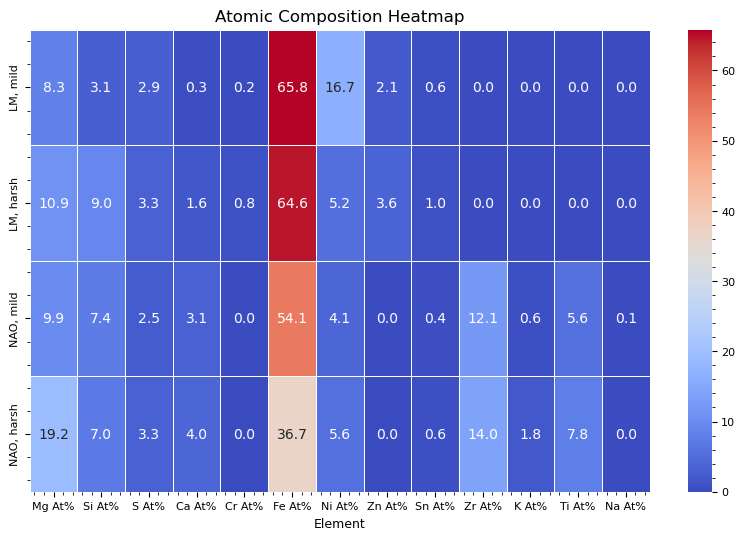

In [15]:
# Compute the mean composition for each sample
df_avg_composition = df_final.groupby("Sample")[element_columns].mean().reset_index()

# Normalize the atomic percentages so they sum to 100%
total_sum = df_avg_composition[element_columns].sum(axis=1)

# Avoid division by zero (in case of empty samples)
df_avg_composition[element_columns] = df_avg_composition[element_columns].div(total_sum, axis=0) * 100

df_heatmap = df_avg_composition.set_index("Sample")

# Create heatmap
fig = plt.figure(figsize=(10, 6))
ax = sns.heatmap(df_heatmap, annot=True, fmt=".1f", cmap="coolwarm", linewidths=0.5)
exps = ['LM, mild', 'LM, harsh', 'NAO, mild', 'NAO, harsh']
ax.set_yticklabels(exps)

# Formatting
plt.title("Atomic Composition Heatmap")
plt.xlabel("Element")
plt.ylabel(None)

# Show plot
fig.savefig('SEM/Atomic_composition.png', dpi = 600)
plt.show()

In [7]:
# Identify unclassified particles where all elements have 0 wt%
unclassified_mask = (df_final[element_columns].sum(axis=1) == 0)

# Create a 'Cluster' column and set '0' for unclassified particles
df_final['Cluster'] = None
df_final.loc[unclassified_mask, 'Cluster'] = 0

# Filter only classified particles (non-unclassified rows)
classified_data = df_final[~unclassified_mask][element_columns]
classified_values = classified_data.values

c:\Users\B363580\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\B363580\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\B363580\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\B363580\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is

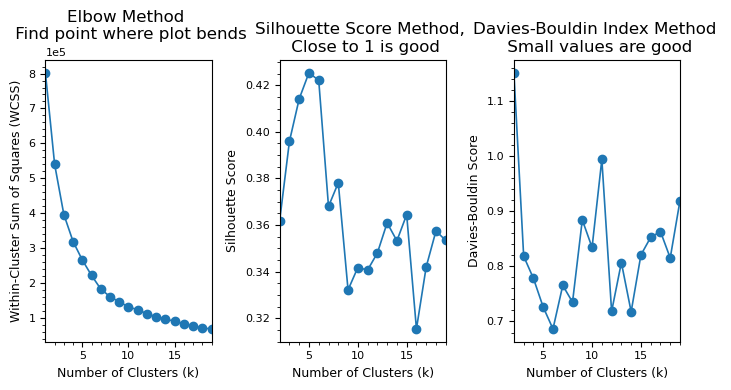

In [8]:
fig = K_means_optimal(classified_values)
fig.savefig(r"SEM\K-optimal.png",dpi=600,bbox_inches='tight')

In [8]:
optimal_components = 6 # Adjust based on analysis
kmeans = KMeans(n_clusters=optimal_components, random_state=42)

# Fit K-means
cluster_labels = kmeans.fit_predict(classified_values)
classified_data['Cluster'] = cluster_labels + 1

# Assign the classified clusters back to df
df_final.loc[classified_data.index, 'Cluster'] = classified_data['Cluster']

df_final['Cluster'] = df_final['Cluster'].astype(int)

c:\Users\B363580\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\B363580\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


C:\Users\B363580\AppData\Local\Temp\ipykernel_7356\2476855216.py:51: RuntimeWarning: invalid value encountered in divide
  normalized_contributions = (cluster_contributions / total_counts) * 100  # Normalize to percentages


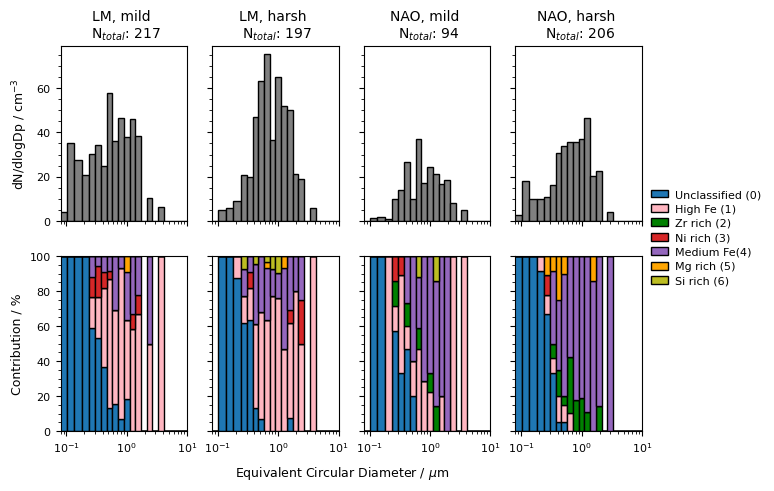

In [11]:
# Create subplots: Top row for solid bar histograms, bottom row for normalized stacked histograms
fig, axs = plt.subplots(nrows=2, ncols=num_samples, figsize=(7.5, 5), sharex=True, sharey="row")

# Colormap and cluster color mapping
cmap = ['tab:blue', 'lightpink', 'green', 'tab:red', 'tab:purple', 'orange', 'tab:olive']
cluster_colors = {cluster: cmap[i] for i, cluster in enumerate(sorted(df_final["Cluster"].unique()))}
all_clusters = sorted(df_final["Cluster"].unique())  # Ensure all clusters are considered

# For use if #optimal_components = 11
# Cluster_names = ["Unclassified", "Sn rich", "Low Fe", "High Fe", "Si rich", "Ca rich", "Ni rich", "Medium Fe", "Zr rich", "Ca + S rich", "Mg rich", "Ti or K rich"]
Cluster_names = ["Unclassified (0)", "High Fe (1)", "Zr rich (2)", "Ni rich (3)", "Medium Fe(4)", "Mg rich (5)", "Si rich (6)"]

titles = ['LM, mild', 'LM, harsh', 'NAO, mild', 'NAO, harsh']

# Loop through each sample and plot
for col, sample in enumerate(samples):
    sample_data = df_final[df_final["Sample"] == sample]  # Filter data for the sample

    ### Top Row: Solid bar histogram
    ax_top = axs[0, col]
    
    # Compute total particle counts per size bin
    total_counts, _ = np.histogram(sample_data["ECD (μm)"] * 1000, bins=size_bins)

    total_counts = total_counts/Partector_correction/Fraction_area_analyzed/sampled_air[col]/dlogDP

    ax_top.bar(size_bins[:-1]/1000, total_counts, width=np.diff(size_bins/1000), align="edge", color="gray", edgecolor="black")
    ax_top.set_title(f"{titles[col]} \n N$_{{total}}$: {len(sample_data)}", fontsize = 10)
    ax_top.set_xscale("log")
    ax_top.set_xlim(80*10**(-3), 10)
    # ax_top.grid(axis="both", which="both", color="k", alpha=0.2)

    ### Bottom Row: Normalized stacked histogram
    ax_bottom = axs[1, col]
    # Calculate histograms for each cluster
    hist_data = []
    for cluster in all_clusters:
        cluster_data = sample_data[sample_data["Cluster"] == cluster]["ECD (μm)"] * 1000
        hist_data.append(cluster_data)
    
    # Stack histograms for clusters
    cluster_hist, _ = np.histogram(sample_data["ECD (μm)"] * 1000, bins=size_bins)
    cluster_contributions = []
    for cluster_data in hist_data:
        counts, _ = np.histogram(cluster_data, bins=size_bins)
        cluster_contributions.append(counts)

    # Normalize stacked histogram to sum to 100% per bin
    cluster_contributions = np.array(cluster_contributions)
    total_counts = cluster_contributions.sum(axis=0)
    normalized_contributions = (cluster_contributions / total_counts) * 100  # Normalize to percentages
    normalized_contributions[np.isnan(normalized_contributions)] = 0  # Handle NaNs in empty bins

    # Plot normalized stacked histogram
    bottom = np.zeros(len(size_bins) - 1)
    for i, cluster in enumerate(all_clusters):
        ax_bottom.bar(size_bins[:-1]/1000, normalized_contributions[i], width=np.diff(size_bins/1000), align="edge",
                      bottom=bottom, label=Cluster_names[i], color=cluster_colors[cluster], edgecolor="black")
        bottom += normalized_contributions[i]

    ax_bottom.set_xscale("log")
    ax_bottom.set_xlim(80*10**(-3), 10)
    ax_bottom.set_ylim(0, 100)
    # ax_bottom.grid(axis="both", which="both", color="k", alpha=0.2)

# Add a shared x-axis label
fig.supxlabel("Equivalent Circular Diameter / $\mu$m", fontsize = 9)
axs[1,0].set_ylabel("Contribution / %")
axs[0,0].set_ylabel("dN/dlogDp / cm$^{-3}$",labelpad=5)
# plt.subplots_adjust(hspace=0.07,wspace=0.15,right=0.85)

# Add a legend for clusters (shared across subplots)
axs[1, -1].legend(bbox_to_anchor=(1.05, 1.4), loc="upper left", borderaxespad=0, frameon = False, fontsize = 8)

fig.savefig(r"SEM\Size_distribution.png",dpi=600,bbox_inches='tight')

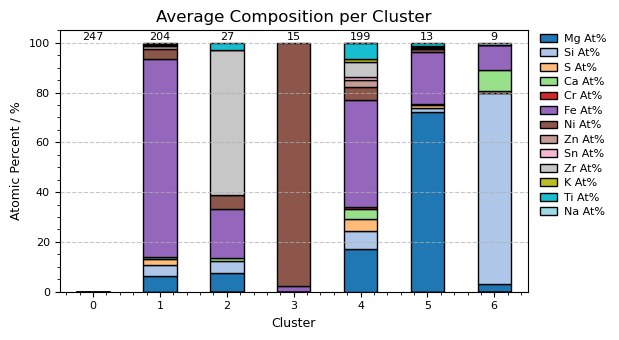

In [11]:
# Compute the average composition per cluster
df_cluster_avg = df_final.groupby("Cluster")[element_columns].mean().reset_index()

particle_counts = [np.sum(df_final['Cluster'] == cluster) for cluster in all_clusters]

# Set the cluster column as index for plotting
df_cluster_avg.set_index("Cluster", inplace=True)

# Normalize the atomic percentages so they sum to 100%
total_sum_cluster = df_cluster_avg[list(df_cluster_avg)].sum(axis=1)

# Avoid division by zero (in case of empty samples)
df_cluster_avg[list(df_cluster_avg)] = df_cluster_avg[list(df_cluster_avg)].div(total_sum_cluster, axis=0) * 100

# Plot the stacked bar chart
ax = df_cluster_avg.plot(kind="bar", stacked=True, figsize=(6.3, 3.5), colormap="tab20",edgecolor="black")
for i, bar in enumerate(particle_counts):
    
    x = i
    ax.text(
            x,
            100 + 0.5,  # Position the text slightly above the bar
            str(particle_counts[i]),  # Number of particles
            ha="center",
            va="bottom",
            fontsize=8,
        )
# Formatting
plt.xlabel("Cluster")
plt.ylabel("Atomic Percent / %")
plt.title("Average Composition per Cluster")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left",borderaxespad=0,frameon = False, fontsize = 8)
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

plt.savefig(r"SEM\Cluster_Composition.png",dpi=300,bbox_inches='tight')